## Supervised Learning: Churn Analysis with KNN

### 先了解KNN分类特点
我们创建一个由一个大圆圈包围的小圆圈组成的数据集。我们先尝试使用logistic回归，然后再使用KK最近邻算法作为对比。

In [2]:
import numpy as np
from sklearn.datasets import make_circles
X, y = make_circles(noise=.1, factor=.5)
print("X.shape:", X.shape)
print("unique labels: ", np.unique(y))

X.shape: (100, 2)
unique labels:  [0 1]


再对这些数据进行可视化。

Populating the interactive namespace from numpy and matplotlib


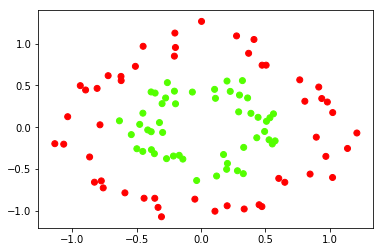

In [3]:
%pylab inline
plt.prism()     # 这个函数来设置较好的颜色
plt.scatter(X[:, 0], X[:, 1], c=y)

设置训练数据和测试数据各占50%。

In [4]:
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

使用逻辑回归来训练模型

In [5]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

评价Logistic回归。我们把训练数据划成圆圈，用真实的标签着色。测试数据用它们的预测着色，并绘制成三角形。

Accuracy of logistic regression on test set: 0.36


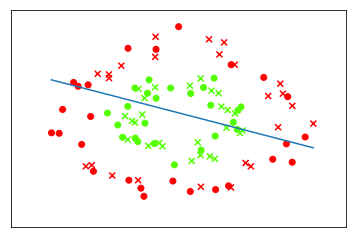

In [7]:
plt.prism()
from utility import plot_decision_boundary
y_pred_test = logreg.predict(X_test)
#plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='+',s=300)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test,marker='x')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plot_decision_boundary(logreg, X)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
print("Accuracy of logistic regression on test set:", logreg.score(X_test, y_test))

看起来分类器的分类效果不好，看到测试样本在决策边界的左边都是绿色，在右边都是红色。下面来看看KNN分类器的工作情况。

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)    # 一般比较多用5 neighbors

In [9]:
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

Accuracy of KNN test set: 0.9


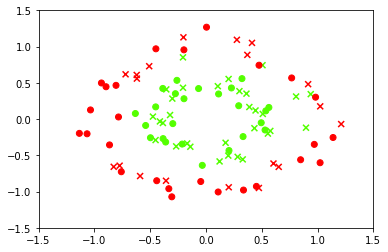

In [10]:
plt.prism() # gives us a nice color map
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='x')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
print("Accuracy of KNN test set:", knn.score(X_test, y_test))

看起来效果好多了，在测试集上也是一样。可以尝试改变K值来获得更好的表现。

### 客户流失分析
流失率（Churn Rate）这个商业术语表达了客户离开或停止支付产品或服务的比率。在许多商业领域中它是一个关键指标，因为开拓一个新客户要比挽留一个老客户的成本高很多 (某些情况下,要高 5 到 20倍)。

了解是什么让顾客参与是非常有价值的，因为它是从制定保留策略到推出业务实践的逻辑基础。因此，越来越多的公司对开发更好的流失检测技术越来越感兴趣，并迫使人开始寻找数据挖掘和机器学习的创新方法。

预测客户流失在许多领域有着广泛的应用。例如，赌场使用预测模型来预测让顾客坐在blackjack桌前的理想空间条件，和奖励那些运气不好的客人前排座位来听Celine Dion的音乐。同样，航空公司可能会向投诉客户提供一流的升级服务。

加载相关的python包

In [11]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

### 数据集 ###

案例用的数据是一份长期的电信客户数据集。

数据很简单。每一行代表签约的电话客户。列是客户属性，包括电话号码、在不同时段使用的通话分钟数、服务发生的费用、帐户持续时间以及客户是否仍然是客户等。

In [12]:
churn_df = pd.read_csv('data/churn.csv')
col_names = churn_df.columns.tolist()

print("Column names:")
print(col_names)

to_show = col_names[:6] + col_names[-6:]

print("\nSample data:")
churn_df[to_show].head(6)
      

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


下面做一些简单的数据预处理，例如删除无关的列，将字符类型转换成布尔型（因为模型不能很地处理）。

In [13]:
# 离散化目标字段Churn
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [14]:
print(len(y))
for i in y:
    print(i,end=',')

3333
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0

In [15]:
# 删除不需要的字段
to_drop = ['State','Area Code','Phone','Churn?']  #Churn?字段也删除，分类标记值存在y中
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [16]:
# 将'yes'/'no' 转成boolean值
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'#🐂🍺

In [17]:
churn_feat_space.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [18]:
# 获取特征字段，以备后用
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [19]:
X = churn_feat_space.as_matrix().astype(np.float) #将数据框churn_feat_space转换成矩阵，值转换成浮点数值
scaler = StandardScaler()
X = scaler.fit_transform(X)   #对矩阵数据进行规范化处理
X.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(3333, 17)

In [20]:
X[:3]

array([[ 0.67648946, -0.32758048,  1.6170861 ,  1.23488274,  1.56676695,
         0.47664315,  1.56703625, -0.07060962, -0.05594035, -0.07042665,
         0.86674322, -0.46549436,  0.86602851, -0.08500823, -0.60119509,
        -0.0856905 , -0.42793202],
       [ 0.14906505, -0.32758048,  1.6170861 ,  1.30794844, -0.33373776,
         1.12450284, -0.33401297, -0.10808036,  0.14486653, -0.10754944,
         1.05857074,  0.14782467,  1.05938994,  1.24048169, -0.60119509,
         1.2411686 , -0.42793202],
       [ 0.9025285 , -0.32758048, -0.61839626, -0.59175986,  1.16830364,
         0.67598459,  1.168464  , -1.57338336,  0.49627857, -1.57389963,
        -0.75686906,  0.19893459, -0.75557074,  0.70312091,  0.21153386,
         0.69715637, -1.1882185 ]])

In [21]:
# 我们现在已有了样本数据X，和标记y
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))      

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


### 判断模型的优劣 

交叉验证（cross validation）将用在这个案例中来对模型进行评估。交叉验证试图防止过拟合(在同样的数据上进行训练和测试)。

In [22]:
from sklearn.model_selection import KFold

def run_cv(X,y,clf_class,**kwargs):#超参数**kwargs是为了传入参数
    # 构造 kfolds 对象
    kf = KFold(n_splits=9)  #折数最少为2，默认是3，折数多一定上会怎加准确率，但增加运行开销
    y_pred = y.copy()
    
    # 通过folds进行迭代
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

我们来比较3个独立的模型：k-nearest-neighbors,support vector machines and random forest。通过交叉验证来判断它们预测的正确率。

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR)))
print("Gradient Boosting Classifier")
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print("Support vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Logistic Regression:
0.861
Gradient Boosting Classifier


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.952
Support vector machines:


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

0.923
Random forest:


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.945
K-nearest-neighbors:
0.895


哪个模型更好些？Random forest表现不错，Gradient Boosting较大潜力，GBDT。

### Precision and recall

准确率的问题是与真实结果不一定相等的。如果分类器预测一个客户会流失，但他/她没有流失，这个并不最坏，也是可以原谅的。然而，如果分类器预测一个客户会返回，结果没有，反而流失了，这就真的糟糕了。

我们可以使用 `scikit-learn` 中的一个函数损失矩阵（confusion matrix)来处理类似问题。损失矩阵告诉我们弃真错误（实际是真，预测为假）和取伪错误（实际是假，预测为真）的情况。

## Confusion matrix and confusion tables: 
列表示真实类，行表示预测类，可以用来评估分类器的表现 

|      | condition True | condition false|
|------|----------------|---------------|
|prediction true|True Positive|False positive|
|Prediction False|False Negative|True Negative|

敏感度,召回率或真阳性率（Recall or True Positive Rate）量化了模型预测正类的能力。

$$TPR = \frac{ TP}{TP + FN}$$ 

特异度，或真阴性率（True Negative Rate）量化了模型预测负类的能力。

$$TNR = \frac{ TN}{FP + TN}$$ 

### Example:

|      | Spam | Ham|
|------|----------------|---------------|
|prediction Spam|100|50|
|Prediction Ham|75|900|

$$TPR = \frac{100}{100 + 75} = 57.14 \%   Sensitive $$

$$TNR = \frac{ 900}{50 + 900} = 94.73 \% Specific $$



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

[[2821   29]
 [ 228  255]]


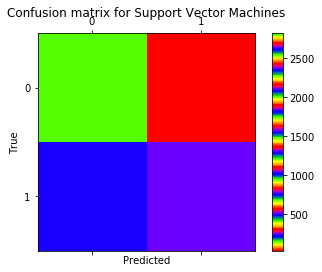

[[2830   20]
 [ 145  338]]


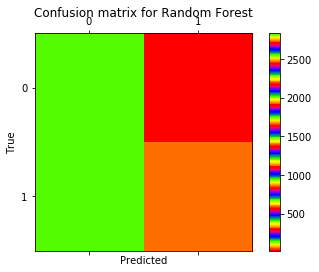

[[2808   42]
 [ 308  175]]


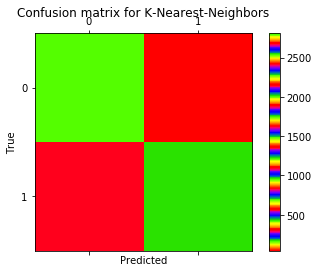

[[2816   34]
 [ 128  355]]


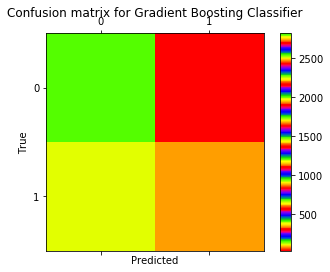

[[2766   84]
 [ 380  103]]


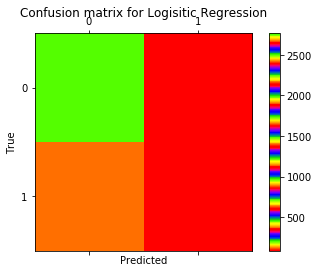

In [24]:
from sklearn.metrics import confusion_matrix  #混淆矩阵
from sklearn.metrics import precision_score   #准确率
from sklearn.metrics import recall_score      #召回率

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

要问的一个重要问题可能是，当个人流失时，我的分类器多长时间才能正确预测？ 这种测量称为“召回”。
快速查看这些测试图表可以证明随机森林对于这个标准显然是最好的。在所有的客户流失情况（结果“1”）中，随机森林正确地从483中检索出332个。这意味着流失“召回”约为68％（330 /482≈2/ 3），远远好于支持向量机 ≈50％）或k-最近邻（≈35％）

另一个重要的问题是“精确”，或者当一个分类器预测一个人会流失时，这个人究竟有多久会流失？ 随机森林再次以大约93％的精度（359个中的332个）；另外两个模型，其中支持向量机略微落后于大约89％（284个中的255个）。 K-nearest-neighbors滞后于大约80％。

虽然这里随机森林的准度，精度和召回率都高于SVC，也并不总是如此。 当不同的测量结果返回不同的长幼强弱顺序时，理解每个等级的值和权衡应该会影响你如何进行判断。


## ROC Plots & AUC

另一个重要的指标是ROC曲线。详情可参见 [academic paper](https://cours.etsmtl.ca/sys828/REFS/A1/Fawcett_PRL2006.pdf). 

简而言之，受试者工作特征（ROC）曲线的曲线下面积（AUC）是将ROC性能降低至代表预期性能的单一值的一种方式。

详细一点，ROC曲线是根据一系列不同的二分类方式（分界值或决定阈），以真阳性率（灵敏度）为纵坐标，假阳性率（1-特异度）为横坐标绘制的曲线。由于随机方法描述了单位间隔内的水平曲线，所以其AUC为0.5。 最小的情况是，分类器的表现应该比这更好，并且它们的分数高于ROC曲线下面积（即ROC曲线下面积更大），它们的预期性能会更好。

也即ROC曲线越靠近左上角,试验的准确性就越高。最靠近左上角的ROC曲线的点是错误最少的最好阈值，其假阳性和假阴性的总数最少。

Support vector machines:


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

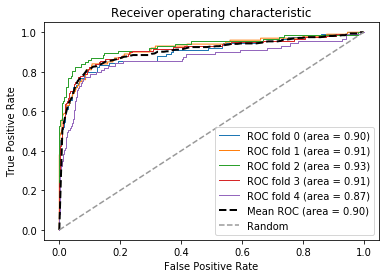

Random forests:


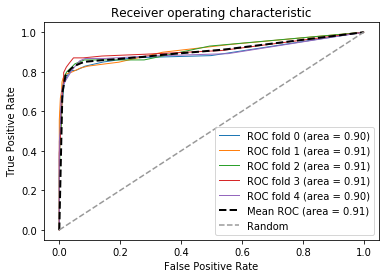

K-nearest-neighbors:


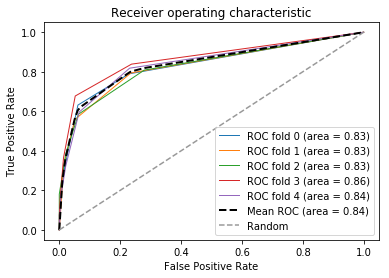

Gradient Boosting Classifier:


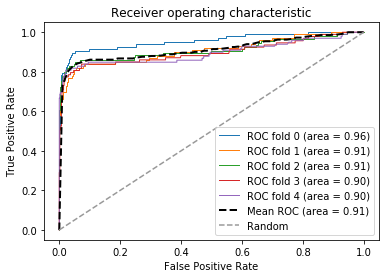

In [25]:
from sklearn.metrics import roc_curve, auc  #使用ROC、AUC
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)  #5折交叉检验
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0                        #y轴，真阳率
    mean_fpr = np.linspace(0, 1, 100)     #x轴, 假阳率
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):   #共5折，每折中训练与测试数据索引
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)  #调用指定分类器及其初始化参数
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1]) #获得ROC指标值
        mean_tpr += interp(mean_fpr, fpr, tpr)  #插值函数  对初始的mean_tpr进行插值
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)    #计算AUC面积
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= kf.n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    #plt.plot(mean_fpr, all_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

## Feature Importance

现在我们已经了解了在特定数据集的每个模型的准确性。我们可以再深入了解一下，以便更好地理解哪些特性或行为会导致我们的客户流失。接下来，我们将使用“RandomForestClassifer”来构建一个决策树集合，以预测客户是否会流失或不流失。

让我们来看看我们的数据集中的前十名与客户流失有关的特征：

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. Account Length (0.160143)
2. Int'l Plan (0.140761)
3. VMail Plan (0.063014)
4. VMail Message (0.062021)
5. Day Mins (0.059692)
6. Day Calls (0.034172)
7. Day Charge (0.031125)
8. Eve Mins (0.029060)
9. Eve Calls (0.022366)
10. Eve Charge (0.020900)


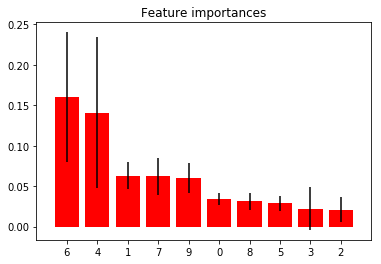

In [26]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

## Thinking in Probabilities

决策制定往往比简单的分类更有可能得益于概率。 “明天有20％的可能性”和“大约55％的考生通过考试”这样的陈述中明显有更多的信息，而不仅仅是“明天不应该下雨”或者“你可能会通过”。“ 对客户流失的概率预测也使我们能够衡量客户的期望值，以及他们的预期损失。您想首先与谁联系，客户有80％的客户流失风险，每年支付2万美元，或者每年价值10万美元的客户有40％的风险？ 每个客户应该花多少钱？

虽然我们正在移动原先关于分类的专业知识，但是能够提出这个问题需要有一些不同的预测。 非常好的是，“scikit-learn”让概率统计变得容易; 案例中的几个模型在他们的类对象中建立了`predict_proba（）`方法。 这使得交叉验证代码只有几行改变。

In [27]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

## How good is good?

确定给出概率而不是类的预测变量有多困难。如果我预测明天下雨的可能性有20％，我会让你们。。。因为明天，它要么下雨，要么没有。

如果说有什么帮助的话，那是预测者没有做出一个预测，他们正在做3000+。 所以每当预测一个事件发生20％的时候，我可以看到这些事件实际发生的频率。 下面我们将使用“pandas”来帮助我们比较随机森林预测值与实际结果。

In [28]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1787
0.1     697
0.2     264
0.3     120
0.9      83
0.8      79
0.7      71
1.0      65
0.4      60
0.5      55
0.6      52
dtype: int64

In [29]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1787,0.029659
1,0.1,697,0.024390
2,0.2,264,0.075758
3,0.3,120,0.141667
4,0.9,83,0.963855
5,0.8,79,0.974684
6,0.7,71,0.845070
7,1.0,65,1.000000
8,0.4,60,0.416667
9,0.5,55,0.581818


我们可以看到随机森林预测有75个人有0.9的流失概率，实际上这个群体的概率是0.97。

## Calibration and Descrimination
### 效能评价（区分度discrimination与校准度calibration）

使用上面的`DataFrame`，我们可以绘制一个非常简单的图形来帮助可视化概率测量。 x轴表示随机森林分配给一组个体的流失概率。 y轴是该组内的实际流失率，并且每个点相对于组的大小被缩放。

![](http://blog.yhathq.com/static/img/ggplot.png)

校准度是一个相对简单的测量，可以概括如下：事件预计发生60％的时间应该发生在60％的时间。 对于所有模型预测的流失风险在30％到40％之间的人来说，这个群体的真实流失率应该是35％左右。 对于上面的图表来看，我的预测与红线有多接近？

区分度，_模型对绿线的预测有多远？_为什么这么重要？

那么，如果我们给每个人分配一个15％的流失概率，那么由于平均数，我们将有接近完美的校准，但是模型将缺乏真正的洞察力。 区分度如果能够隔离远离基本集合的组，则给予模型更好的分数。

Equations are replicated from [Yang, Yates, and Smith (1991)](https://www.google.com/search?q=Measures+of+Discrimination+Skill+in+Probabilistic+Judgment&oq=Measures+of+Discrimination+Skill+in+Probabilistic+Judgment) 

In [30]:

from churn_measurements import calibration, discrimination
from sklearn.metrics import roc_curve, auc
from scipy import interp

      
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print("  %-20s %.4f" % ("Calibration Error", calibration(churn_prob, is_churn)))
    print("  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,is_churn)))

    print("注意 -- 低calibration更好, 高discrimination更好")

SyntaxError: from __future__ imports must occur at the beginning of the file (cell_name, line 7)

In [31]:
print("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print("Random forests:")
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print("K-nearest-neighbors:")
print_measurements(run_prob_cv(X,y,KNN))

print("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X,y,GBC))

print("Random Forest:")
print_measurements(run_prob_cv(X,y,RF))

Support vector machines:


NameError: name 'print_measurements' is not defined

与之前的分类比较不同，随机森林在这里并不是那么明显。 虽然它很好地区分高低概率的流失事件，但却难以为这些事件分配准确的概率估计值。 例如，随机森林预计有30％的流失率的群体真正的流失率为20％。显然还有更多的工作要做。。。